In [4]:
import pickle
import itertools
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
import sacrebleu
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [5]:
lines = list(open('./model_annotations.aligned.scored.jsonl', 'rt'))

In [6]:
obj = json.loads(lines[10])
obj

{'id': 'dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2',
 'decoded': "paul merson has restarted his row with andros townsend after the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley on sunday . ' paul merson had another dig at andros townsend after his appearance for tottenham against burnley . townsend was brought on in the 83rd minute for tottenham as they drew 0-0 against burnley .",
 'expert_annotations': [{'coherence': 3,
   'consistency': 5,
   'fluency': 5,
   'relevance': 3},
  {'coherence': 2, 'consistency': 5, 'fluency': 4, 'relevance': 2},
  {'coherence': 3, 'consistency': 5, 'fluency': 5, 'relevance': 4}],
 'turker_annotations': [{'coherence': 2,
   'consistency': 2,
   'fluency': 2,
   'relevance': 2},
  {'coherence': 2, 'consistency': 2, 'fluency': 2, 'relevance': 2},
  {'coherence': 2, 'consistency': 2, 'fluency': 2, 'relevance': 2},
  {'coherence': 2, 'consistency': 2, 'fluency': 2, 'relevance': 2},
  {'coher

In [7]:
def annotations(x, annotations, agg=lambda x: np.mean(list(x.values()))):
    scores = []
    if annotations not in x:
        return []
    
    for expert in x[annotations]:
        scores.append(agg(expert)) 
    return scores

In [8]:
data = []

for line in lines:
    obj = json.loads(line)
    
    row = []
    row.append(obj['id'])
    row.append(obj['decoded'])
    row.append(obj['references'][0])
    row.append(obj['model_id'])
    
    row.append(obj['metric_scores_11']['rouge']['rouge_4_f_score'])
    row.append(obj['metric_scores_11']['meteor'])
    row.append(obj['metric_scores_11']['mover_score'])
    row.append(obj['metric_scores_11']['bert_score_f1'])
    row.append(obj['metric_scores_1']['supert'][0])
    
    for expert_annotation in annotations(obj, 'expert_annotations'):
        r = row.copy()
        r.append('expert')
        r.append(expert_annotation)
        data.append(r)
        
    for expert_annotation in annotations(obj, 'turker_annotations'):
        r = row.copy()
        r.append('turker')
        r.append(expert_annotation)
        data.append(r)
    
df = pd.DataFrame(data)
df.columns = ['id', 'output', 'reference_1', 'system', 'r11_rouge_4_f_score', 'r11_meteor', 'r11_mover_score', 'r11_bert_score', 'r1_supert', 'type', 'score']
pickle.dump(df, open('summeval_flat.pkl', 'wb'))

df.head(1)

,id,output,reference_1,system,r11_rouge_4_f_score,r11_meteor,r11_mover_score,r11_bert_score,r1_supert,type,score
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,Andros Townsend an 83rd minute sub in Tottenha...,M11,0.00185,0.220548,0.207145,0.399867,0.508232,expert,2.25


<AxesSubplot:xlabel='score', ylabel='r1_supert'>

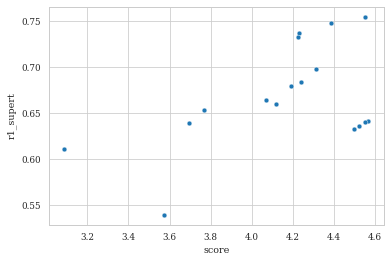

In [9]:
expert_df = df[df.type == 'expert']
expert_means = expert_df.groupby('system')['score'].mean()

metric_df = df[~df.duplicated(['id','system'])]
metric_means = metric_df.groupby('system')['r1_supert'].mean()

sns.scatterplot(x=expert_means, y=metric_means)

In [10]:
def pairs(x):
    systems = x.system.unique()

    for i, j in itertools.combinations(systems, 2):
        yield i, j
            
all_pairs = list(pairs(df))
print(len(all_pairs))
print(all_pairs[-1])

def get_preds(all_pairs, scores):
    preds = np.zeros(len(all_pairs))
    if type(scores) == type({}):
        for ii, (i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores[i] - scores[j] > 0 else 0
    else:
        for ii, (i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores.loc[i] - scores.loc[j] > 0 else 0
            
    return preds

true_preds = get_preds(all_pairs, expert_means)
true_preds

136
('M9', 'M23_dynamicmix')


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [11]:
# adopted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_noise_decomposition(metric_results, human_results, true_preds, no_bias=False):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    optimal_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=human_results)
    
    if no_bias:
        main_predictions = optimal_predictions
    true_preds = optimal_predictions
    
    avg_expected_loss = (human_results != metric_results).mean()

    noises = (human_results != true_preds).mean(axis=0)
    probs = (metric_results == true_preds).mean(axis=0)

    avg_noise_contrib = ((2 * probs - 1) * noises).mean()

    avg_bias = (main_predictions != true_preds).mean()

    signs = (main_predictions == true_preds).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib

In [50]:
cached = [ (i, pd.DataFrame(g)) for i, g in expert_df.groupby(['system']) ]
labels = [ i[0] for i in cached ]

def f(metric):
    groups = expert_df.groupby(['system']).apply(lambda x: x.sample(frac=1, replace=True))
    observed_means = groups['score'].groupby(level=[0]).mean()

    return get_preds(all_pairs, observed_means)

WORKERS = 12
TRIALS = 10000
with Pool(WORKERS) as p:
    it = tqdm(p.imap_unordered(f, [None]*TRIALS, chunksize=20), total=TRIALS)
    output = list(it)
    human_results = np.array([ i for i in output ], dtype=np.int64)
    
# optimal predictions
optimal_predictions = np.apply_along_axis(lambda x:
                                   np.argmax(np.bincount(x)),
                                   axis=0,
                                   arr=human_results)

optimal_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0])

In [58]:
cached = [ (i, pd.DataFrame(g)) for i, g in expert_df.groupby(['system']) ]
labels = [ i[0] for i in cached ]

def f(x):
    (n1, n2), ratio = x
    
    groups = [ g.sample(frac=1, replace=True) for i, g in cached ]
    observed_means = [ g['score'].mean() for g in groups ]
    observed_means = { label:mean for label, mean in zip(labels, observed_means) }
    
    # humans
    groups = [ g.sample(n=n1, replace=True) for i, g in cached ]
    human_means = [ g['score'].mean() for g in groups ]
    human_means = { label:mean for label, mean in zip(labels, human_means) }

    # theoretical
    groups = [ g.sample(n=int(n2*ratio), replace=True) for i, g in cached ]
    pa_means = [ g['score'].mean() for g in groups ]
    pa_means = { label:mean for label, mean in zip(labels, pa_means) }

    return get_preds(all_pairs, observed_means), get_preds(all_pairs, human_means), get_preds(all_pairs, pa_means)

WORKERS = 12
NUM_TRIALS = 10000
CHUNKSIZE = int(NUM_TRIALS / WORKERS / 10)
metrics = list(zip(range(50, 301, 50), range(50, 301, 50)))
results = {}

with Pool(WORKERS) as p:
    for metric in tqdm(metrics):
        it = tqdm(p.imap_unordered(f, [(metric, 1.201)]*NUM_TRIALS, chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)

        label_results = np.array([ i[0] for i in output ], dtype=np.int64)
        human_results = np.array([ i[1] for i in output ], dtype=np.int64)
        pa_results = np.array([ i[2] for i in output ], dtype=np.int64)
        
        results[metric] = (bias_var_noise_decomposition(human_results, label_results, true_preds, no_bias=True),
                           bias_var_noise_decomposition(pa_results, label_results, true_preds, no_bias=True))

In [61]:
for metric, (human, pa) in sorted(list(results.items()), key=lambda x: x[1][0]):
    avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib = human
    print(metric)
    print(avg_expected_loss)
    print(avg_noise_contrib + avg_bias + avg_var_contrib)

(300, 300)
0.04499705882352941
0.04518454941176472
(250, 250)
0.04683014705882353
0.04710479382352941
(200, 200)
0.049706617647058825
0.049700104999999994
(150, 150)
0.05487279411764706
0.0546897305882353
(100, 100)
0.0626139705882353
0.061707532499999995
(50, 50)
0.07546029411764706
0.07594689397058824


In [62]:
bvd_results = json.load(open('bvd_results_summeval.json', 'rt'))
print(bvd_results)

{'true_preds': [0.032175367647058827, 0.0, 0.0, 0.03217536764705882], 'human': [0.044517279411764706, 0.0, 0.032179779411764704, 0.012568363676470587], 'r11_rouge_4_f_score': [0.2802143382352941, 0.25, 0.02295477941176471, 0.009502532904411764], 'r11_meteor': [0.26605625, 0.25735294117647056, 0.0031735294117647066, 0.007101156470588237], 'r11_mover_score': [0.34414632352941177, 0.3602941176470588, -0.018124632352941178, 0.0033255085661764725], 'r11_bert_score': [0.3047919117647059, 0.29411764705882354, -0.00023161764705882087, 0.012537311617647057], 'r1_supert': [0.35058676470588235, 0.33088235294117646, 0.014080514705882353, 0.006919467610294118]}


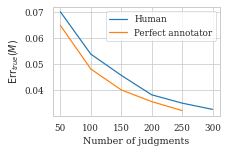

In [66]:
y = [ results[i][0][2] for i in metrics]
y_pa = [ results[i][1][2] for i in metrics ]


plt.figure(figsize=(3, 2.))
ax = sns.lineplot(x=[ i[0] for i in metrics ], y=y, label='Human')
sns.lineplot(x=[ i[1] for i in metrics ][:-1], y=y_pa[:-1], label='Perfect annotator')
ax.set(xlabel='Number of judgments', ylabel='$\\mathrm{Err}_{true}(M)$')
ax.legend(loc='upper right')
    
#plt.axvspan(100, 600, color='grey', alpha=0.1)
plt.savefig('human_comparison_summeval.pdf', bbox_inches='tight')